In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("GeneratedXAUUSD dbot.csv")


In [3]:
df.head()

,Time,Open,High,Low,Close,Tick Volume
0,1.396483e+09,1286.69,1289.01,1281.55,1286.34,49277.0
1,1.396570e+09,1286.86,1306.70,1284.17,1302.66,91423.0
2,1.396829e+09,1303.65,1304.02,1295.52,1296.84,28762.0
3,1.396915e+09,1295.79,1314.28,1295.79,1308.31,29838.0
4,1.397002e+09,1308.14,1314.99,1300.80,1311.51,32383.0


In [4]:
# Change the position of the 'B' column
df = df[['Time','Close', 'Tick Volume']]
df.tail()

,Time,Close,Tick Volume
96401,1.704215e+09,2064.79,17931.0
96402,1.704217e+09,2059.29,22342.0
96403,1.704218e+09,2065.39,16918.0
96404,1.704220e+09,2066.04,8295.0
96405,1.704222e+09,2065.76,3181.0


In [5]:
x = df.values
print(x)

[[1.3964832e+09 1.2863400e+03 4.9277000e+04]
 [1.3965696e+09 1.3026600e+03 9.1423000e+04]
 [1.3968288e+09 1.2968400e+03 2.8762000e+04]
 ...
 [1.7042184e+09 2.0653900e+03 1.6918000e+04]
 [1.7042202e+09 2.0660400e+03 8.2950000e+03]
 [1.7042220e+09 2.0657600e+03 3.1810000e+03]]


In [6]:
closing_prices = x[:,1:2]
closing_prices = closing_prices.reshape(-1)
print(closing_prices[-200:])

[2063.29 2064.   2064.68 2063.91 2063.9  2063.97 2064.02 2063.9  2062.75
 2064.26 2063.99 2063.7  2064.22 2063.8  2061.39 2061.91 2061.84 2062.32
 2063.77 2063.57 2063.48 2062.47 2061.72 2062.02 2058.68 2060.58 2057.
 2057.79 2056.73 2058.71 2059.44 2058.91 2057.63 2058.68 2058.23 2060.19
 2061.62 2063.81 2068.33 2067.41 2067.71 2066.33 2066.09 2064.68 2065.46
 2066.33 2066.6  2065.29 2065.24 2066.19 2064.45 2064.45 2065.79 2065.7
 2064.6  2066.44 2065.02 2065.75 2065.95 2066.99 2067.31 2068.53 2068.25
 2063.73 2064.64 2067.4  2068.08 2068.98 2067.6  2067.35 2068.22 2068.92
 2070.2  2077.02 2078.85 2080.43 2081.6  2080.79 2081.8  2081.69 2078.39
 2077.06 2077.45 2076.71 2078.1  2076.65 2077.5  2078.54 2079.44 2079.98
 2079.73 2083.89 2086.98 2086.48 2087.94 2086.05 2087.17 2086.68 2086.49
 2087.31 2085.74 2084.84 2085.76 2085.64 2086.07 2077.43 2077.33 2074.82
 2076.92 2078.06 2077.18 2077.36 2075.41 2074.85 2076.45 2076.61 2072.91
 2075.16 2078.85 2079.69 2077.18 2075.46 2074.14 2075.

In [7]:
def trend_signals(closing_prices, min_gap=3):
  """
  This function analyzes an array of closing prices and generates an array
  with trend start and end signals, requiring a minimum gap of 5 between changes.

  Args:
      closing_prices: A NumPy array of closing prices.
      min_gap: The minimum number of neutral (0) values required between trend changes (default: 5).

  Returns:
      A NumPy array of trend signals with the following meanings:
      0: Neutral, no trend detected.
      1: Start of an uptrend.
      2: Start of a downtrend.
      3: End of both uptrend and downtrend.
  """

  signals = np.zeros(len(closing_prices), dtype=int)
  signals = list(signals)
  current_trend = 0  # 0: Neutral, 1: Uptrend, 2: Downtrend
  neutral_counter = 0

  for i in range(1, len(closing_prices)):
    previous_close = closing_prices[i-1]
    current_close = closing_prices[i]

    if current_trend == 0:
      # Check for uptrend start
      if current_close > previous_close:
        neutral_counter = 0
        signals[i] = 1
        current_trend = 1
      # Check for downtrend start
      elif current_close < previous_close:
        neutral_counter = 0
        signals[i] = 2
        current_trend = 2
    elif current_trend == 1:
      # Check for downtrend within uptrend
      if current_close < previous_close:
        if neutral_counter >= min_gap:
          # Mark end of previous uptrend
          signals[i-1] = 3
          # Start of downtrend
          signals[i] = 2
          current_trend = 2
          neutral_counter = 0
        else:
          # Not enough neutrals, remain in uptrend
          neutral_counter += 1
    elif current_trend == 2:
      # Check for uptrend within downtrend
      if current_close > previous_close:
        if neutral_counter >= min_gap:
          # Mark end of previous downtrend
          signals[i-1] = 3
          # Start of uptrend
          signals[i] = 1
          current_trend = 1
          neutral_counter = 0
        else:
          # Not enough neutrals, remain in downtrend
          neutral_counter += 1
    else:
      # Reset neutral counter on state change
      neutral_counter = 0

  # Mark the end of the last trend on the last price
  if current_trend != 0:
    signals[-1] = 3

  return signals




In [8]:
signals = trend_signals(closing_prices, 4)

In [9]:
success = 0
corrected = 0
extended = 0

for i in range(len(signals)):
  if signals[i] == 1:
    for ii in range(i,len(signals)):
      if signals[ii] == 3:
        if closing_prices[i] < closing_prices[ii]:
          success += 1
          ## new update
          for iii in range(ii,len(signals)):
            if signals[iii] == 1:
              signals[ii] = 0
              signals[iii] = 0
              extended += 1
              break
            elif signals[iii] == 2:
              break

        elif closing_prices[i] > closing_prices[ii]:
          signals[i] = 2
          ## new update
          for iii in range(ii,len(signals)):
            if signals[iii] == 1:
              break
            elif signals[iii] == 2:
              signals[ii] = 0
              signals[iii] = 0
              extended += 1
              break

          corrected += 1
        else:
          signals[i] = 0
          signals[ii] = 0
        break


  elif signals[i] == 2:
    for ii in range(i,len(signals)):
      if signals[ii] == 3:
        if closing_prices[i] < closing_prices[ii]:
          signals[i] = 1
          ## new update
          for iii in range(ii,len(signals)):
            if signals[iii] == 1:
              signals[ii] = 0
              signals[iii] = 0
              extended += 1
              break
            elif signals[iii] == 2:
              break

          corrected += 1
        elif closing_prices[i] > closing_prices[ii]:
          success += 1
          ## new update
          for iii in range(ii,len(signals)):
            if signals[iii] == 1:
              break
            elif signals[iii] == 2:
              signals[ii] = 0
              signals[iii] = 0
              extended += 1
              break


        else:
          signals[i] = 0
          signals[ii] = 0
        break

print(success, " success from the label ")
print(corrected, " corrected after tuning")
print(extended, " extended signal after analysing")

3742  success from the label 
2979  corrected after tuning
2979  extended signal after analysing


In [10]:
## Data final corrector to reduce noise
success = 0
neutralise = 0

for i in range(len(signals)):

  if signals[i] == 1:
    for ii in range(i + 1, len(signals)):
      if signals[ii] == 3:
        if len(signals) > ii + 1:
          #print(1," checking")
          if signals[ii + 1] == 1:
            signals[ii] = 0
            signals[ii + 1] = 0
            neutralise += 1
          else:
            success += 1

        break


  elif signals[i] == 2:

    for ii in range(i + 1, len(signals)):
      if signals[ii] == 3:
        if len(signals) > ii + 1:
          #print(2," checking")
          if signals[ii + 1] == 2:
            signals[ii] = 0
            signals[ii + 1] = 0
            neutralise += 1
          else:
            success += 1

        break

print(success, " success from the label ")
print(neutralise, " neutralise after tuning by converting ")


2569  success from the label 
2076  neutralise after tuning by converting 


In [11]:
print(signals)
one = 0
two = 0
three = 0
zero = 0
for i in range(len(signals)):
  if signals[i] == 1: one += 1
  elif signals[i] == 2: two += 1
  elif signals[i] == 3: three += 1
  else: zero += 1

print("0 is ",zero)
print("1 is ",one)
print("2 is ",two)
print("3 is ",three)

[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 

In [12]:
for i in range(len(signals)):
  if(signals[i] == 1):
    for ii in range(i,len(signals)):
      if(signals[ii] == 0):
        signals[ii] = 1
      elif(signals[ii] == 3):
        break
  if(signals[i] == 2):
    for ii in range(i,len(signals)):
      if(signals[ii] == 0):
        signals[ii] = 2
      elif(signals[ii] == 3):
        break

one = 0
two = 0
three = 0
zero = 0
for i in range(len(signals)):
  if signals[i] == 1: one += 1
  elif signals[i] == 2: two += 1
  elif signals[i] == 3: three += 1
  else: zero += 1

print("0 is ",zero)
print("1 is ",one)
print("2 is ",two)
print("3 is ",three)

0 is  38
1 is  46854
2 is  44869
3 is  4645


In [13]:
signals = np.array(signals)
print(signals)

[0 2 2 ... 2 2 3]


In [14]:
print(closing_prices.shape)
print(signals.shape)
signals

(96406,)
(96406,)


array([0, 2, 2, ..., 2, 2, 3])

In [15]:
t_cp = closing_prices[-200:]
t_s = signals[-200:]
print(t_cp)

[2063.29 2064.   2064.68 2063.91 2063.9  2063.97 2064.02 2063.9  2062.75
 2064.26 2063.99 2063.7  2064.22 2063.8  2061.39 2061.91 2061.84 2062.32
 2063.77 2063.57 2063.48 2062.47 2061.72 2062.02 2058.68 2060.58 2057.
 2057.79 2056.73 2058.71 2059.44 2058.91 2057.63 2058.68 2058.23 2060.19
 2061.62 2063.81 2068.33 2067.41 2067.71 2066.33 2066.09 2064.68 2065.46
 2066.33 2066.6  2065.29 2065.24 2066.19 2064.45 2064.45 2065.79 2065.7
 2064.6  2066.44 2065.02 2065.75 2065.95 2066.99 2067.31 2068.53 2068.25
 2063.73 2064.64 2067.4  2068.08 2068.98 2067.6  2067.35 2068.22 2068.92
 2070.2  2077.02 2078.85 2080.43 2081.6  2080.79 2081.8  2081.69 2078.39
 2077.06 2077.45 2076.71 2078.1  2076.65 2077.5  2078.54 2079.44 2079.98
 2079.73 2083.89 2086.98 2086.48 2087.94 2086.05 2087.17 2086.68 2086.49
 2087.31 2085.74 2084.84 2085.76 2085.64 2086.07 2077.43 2077.33 2074.82
 2076.92 2078.06 2077.18 2077.36 2075.41 2074.85 2076.45 2076.61 2072.91
 2075.16 2078.85 2079.69 2077.18 2075.46 2074.14 2075.

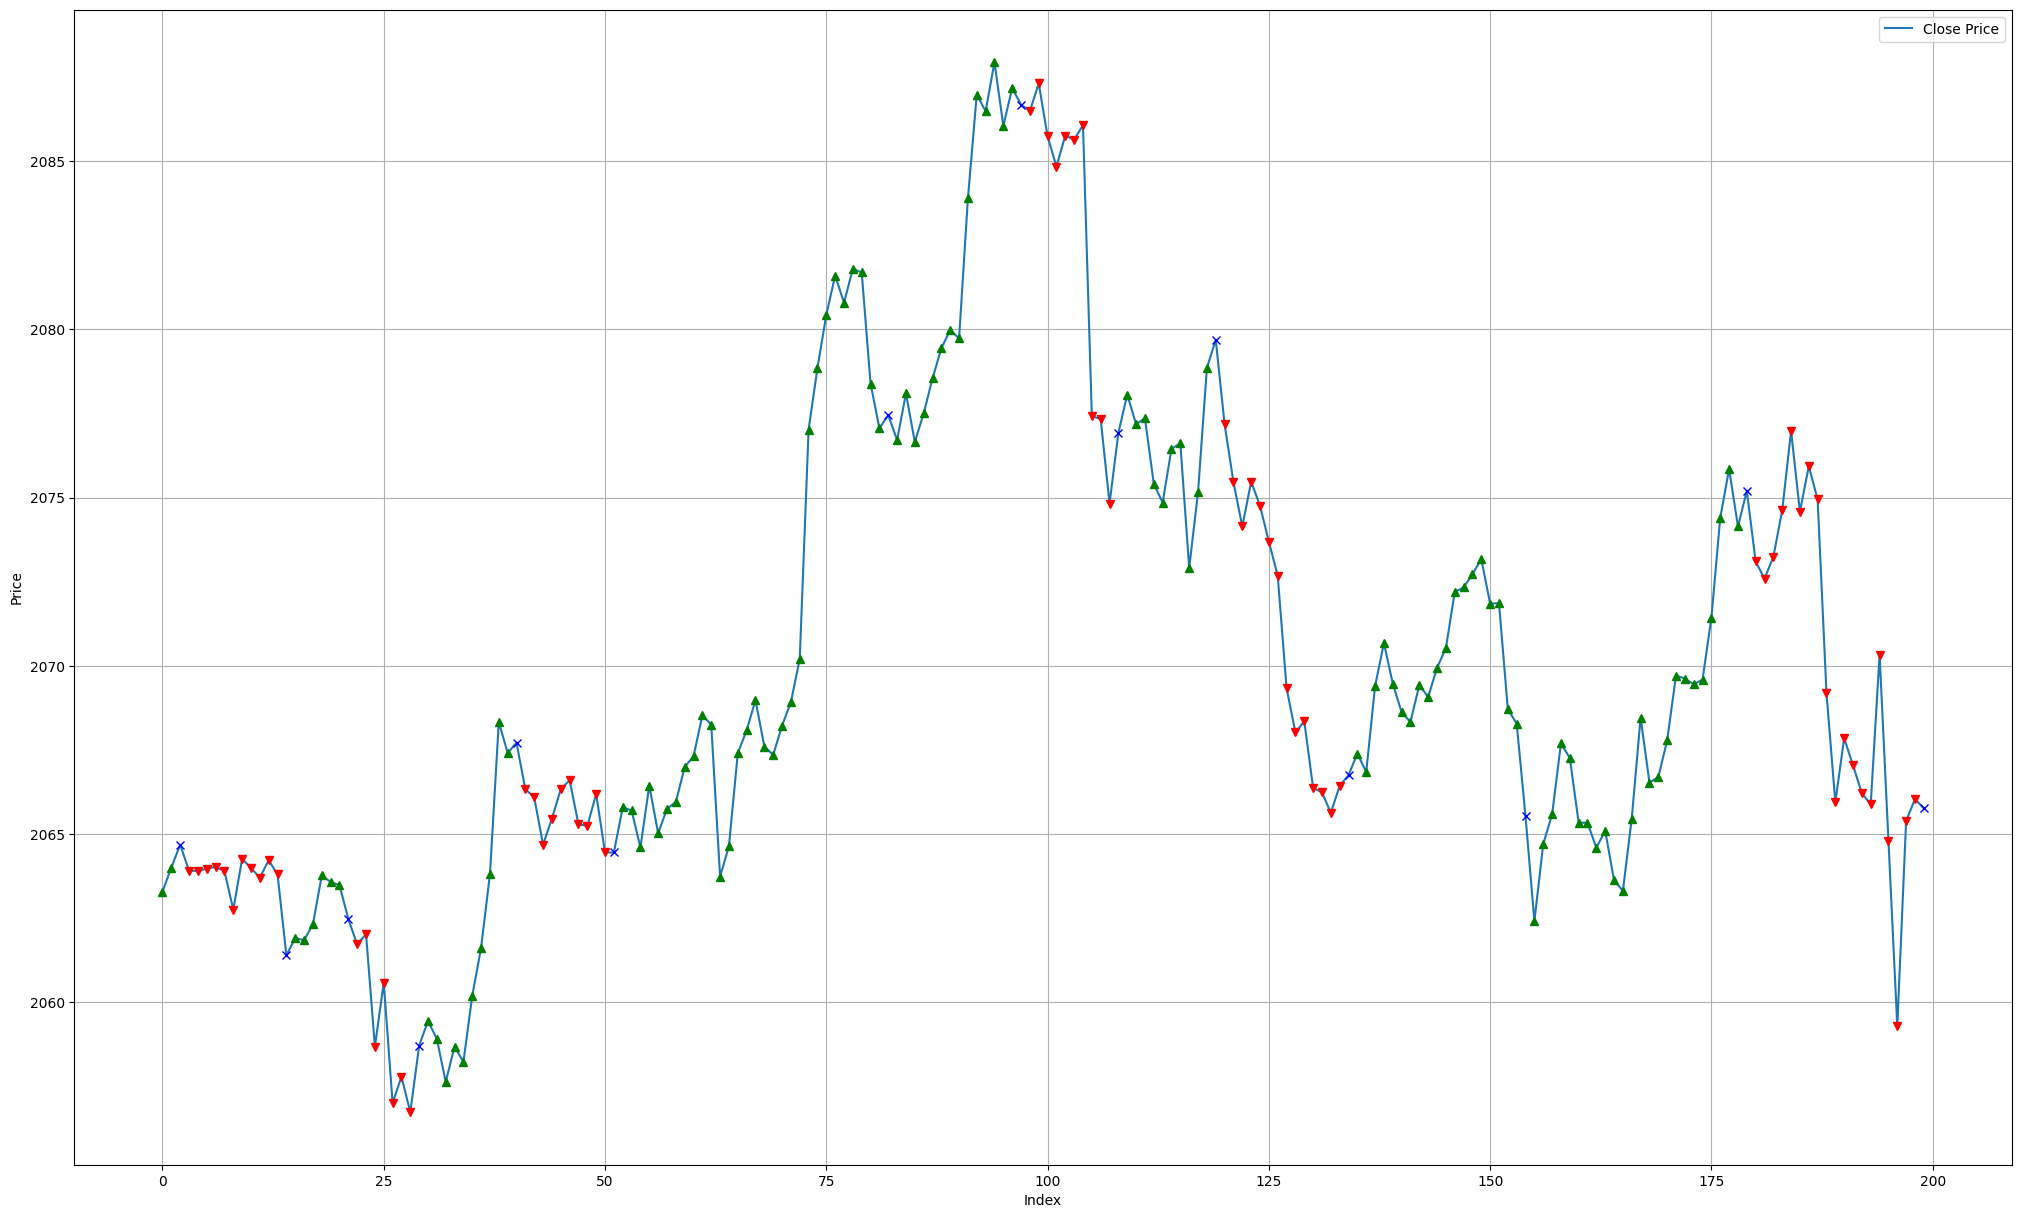

In [16]:
# Plot close price and trend signals
plt.figure(figsize=(25, 15))
plt.plot(t_cp, label='Close Price')

# Use different colors and markers for trend signals
colors = ['black', 'green', 'red','blue']
markers = [".",'^', 'v', 'x']
for i, signal in enumerate(t_s):
  plt.plot(i, t_cp[i], marker=markers[signal], color=colors[signal])

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Analyze the plot to verify the signal correctness for your specific price data.

In [17]:
print(signals[-100:])
y = signals


[2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3]


In [18]:
x_train = x[:-1000,:]
y_train = y[:-1000]

x_test = x[-1000:,:]
y_test = y[-1000:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.08, random_state=42)
print(x_test.shape)

(1000, 3)


In [19]:
x_test = x[-1000:,:]
y_test = y[-1000:]
print(x_test[-20:])


[[1.7041878e+09 2.0731000e+03 6.9220000e+03]
 [1.7041896e+09 2.0725900e+03 8.6230000e+03]
 [1.7041914e+09 2.0732400e+03 7.1630000e+03]
 [1.7041932e+09 2.0746200e+03 5.9360000e+03]
 [1.7041950e+09 2.0769800e+03 6.1620000e+03]
 [1.7041968e+09 2.0745800e+03 6.5640000e+03]
 [1.7041986e+09 2.0759300e+03 5.3320000e+03]
 [1.7042004e+09 2.0749500e+03 6.7190000e+03]
 [1.7042022e+09 2.0691900e+03 9.5510000e+03]
 [1.7042040e+09 2.0659400e+03 8.5120000e+03]
 [1.7042058e+09 2.0678500e+03 7.3550000e+03]
 [1.7042076e+09 2.0670400e+03 1.3183000e+04]
 [1.7042094e+09 2.0662100e+03 1.3935000e+04]
 [1.7042112e+09 2.0658800e+03 1.1837000e+04]
 [1.7042130e+09 2.0703300e+03 2.4475000e+04]
 [1.7042148e+09 2.0647900e+03 1.7931000e+04]
 [1.7042166e+09 2.0592900e+03 2.2342000e+04]
 [1.7042184e+09 2.0653900e+03 1.6918000e+04]
 [1.7042202e+09 2.0660400e+03 8.2950000e+03]
 [1.7042220e+09 2.0657600e+03 3.1810000e+03]]


In [20]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train)
print(x_test)

[[ 0.46008077  1.10046598 -0.3219231 ]
 [-0.93089959 -0.94815986 -0.47530541]
 [-0.70913708 -0.66278719 -0.35488684]
 ...
 [ 1.04309011  1.14292295 -0.49683275]
 [-1.92771711 -1.34557079 -0.53024497]
 [-1.11768439 -1.068552   -0.52396617]]
[[1.69458562 1.71325576 2.31809129]
 [1.69460932 1.70514253 1.55454342]
 [1.69463302 1.71026487 1.15382095]
 ...
 [1.73328387 1.79043461 3.11617259]
 [1.73330756 1.79266919 1.18252407]
 [1.73333126 1.7917066  0.03574469]]


In [21]:
print(x.shape)
print(y.shape)

(96406, 3)
(96406,)


In [22]:
print(x_train.shape)
print(x_test.shape)

(87773, 3)
(1000, 3)


In [23]:
forest = RandomForestClassifier(n_estimators= 400,n_jobs=-1,criterion="gini",verbose=1, warm_start=True, random_state=42)
forest.fit(x_train,y_train)
score = forest.score(x_test, y_test)
print(score)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s


0.503


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   12.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.0s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.0s finished


[1 1 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 1 2 2 1 1 1 1 2 2 2 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 2 2 2 2
 1 2 2 2 2 1 2 1 1 2 2 2 2 2 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 1 1
 1 1 2 1 2 2 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

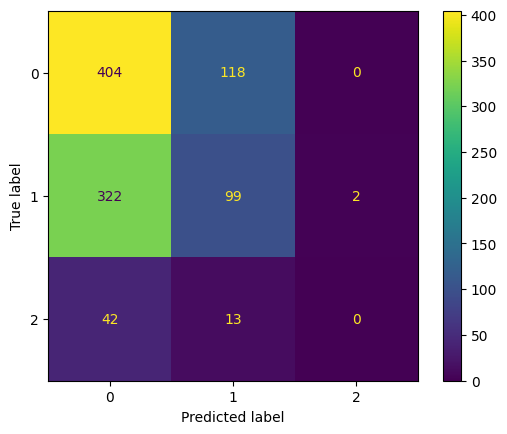

In [24]:
y_pred = forest.predict(x_test)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [25]:
closing_prices = sc.inverse_transform(x_test)
print(closing_prices)

[[1.7012790e+09 2.0429400e+03 1.3359000e+04]
 [1.7012808e+09 2.0405800e+03 9.9540000e+03]
 [1.7012826e+09 2.0420700e+03 8.1670000e+03]
 ...
 [1.7042184e+09 2.0653900e+03 1.6918000e+04]
 [1.7042202e+09 2.0660400e+03 8.2950000e+03]
 [1.7042220e+09 2.0657600e+03 3.1810000e+03]]


In [26]:
closing_prices = closing_prices[:,1:2]
closing_prices = closing_prices.reshape(-1)
#print(closing_prices)

In [27]:
t_cp = closing_prices[-200:]
t_s = y_pred[-200:]

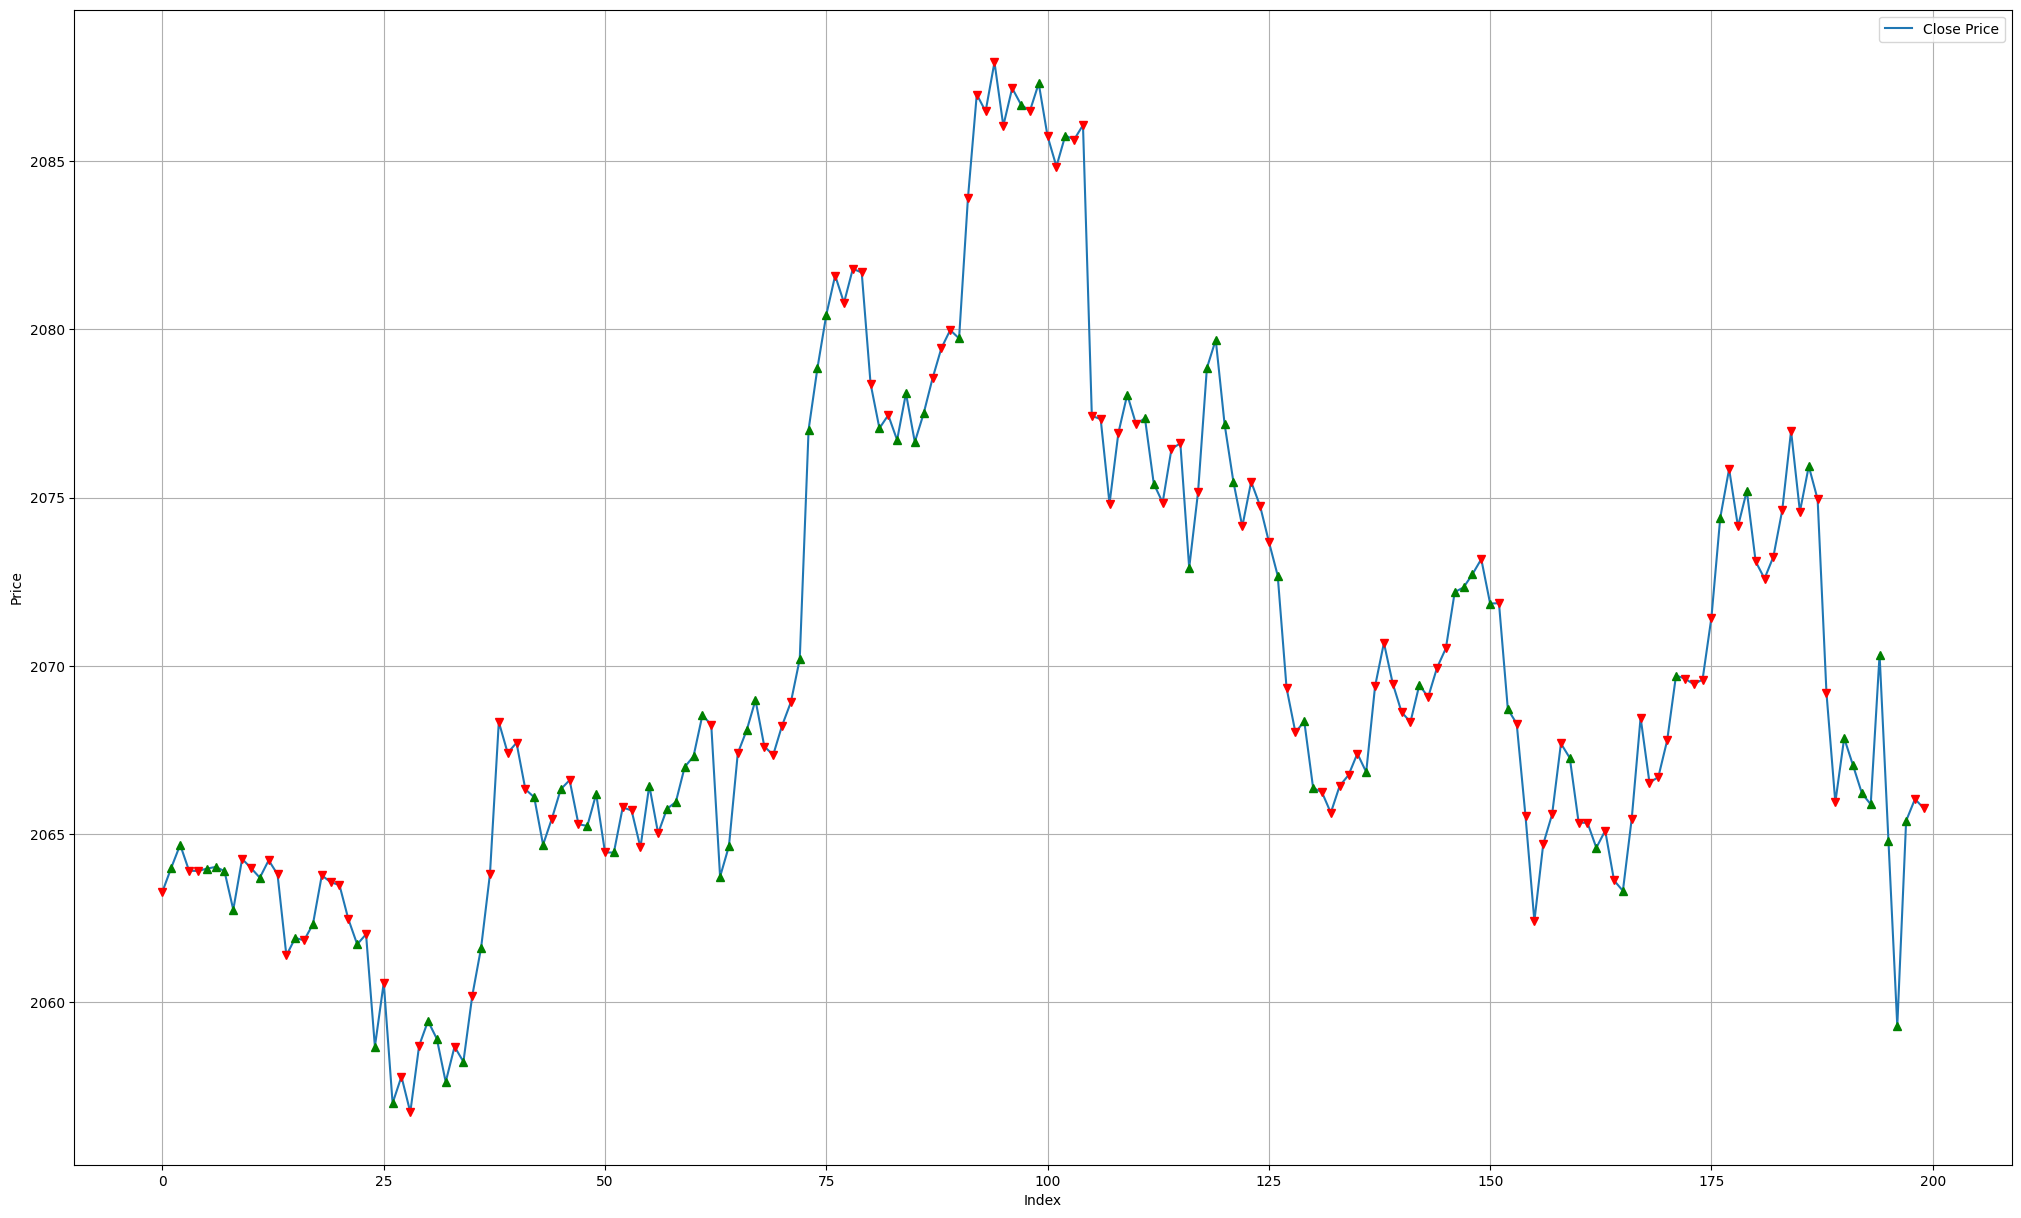

In [28]:
# Plot close price and trend signals
plt.figure(figsize=(25, 15))
plt.plot(t_cp, label='Close Price')

# Use different colors and markers for trend signals
colors = ['black', 'green', 'red','blue']
markers = [".",'^', 'v', 'x']
for i, signal in enumerate(t_s):
  plt.plot(i, t_cp[i], marker=markers[signal], color=colors[signal])

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Analyze the plot to verify the signal correctness for your specific price data.